# Overcomplete Autoencoders with PyTorch¶

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
figsize=(15, 6)
plt.style.use('fivethirtyeight')

In [2]:
# Fashion-MNIST data loader
train_dataset = dsets.FashionMNIST(root='./data',
                                   train=True,
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = dsets.FashionMNIST(root='./data',
                                  train=False,
                                  transform=transforms.ToTensor())


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# Batch size, iterations and epochs
batch_size = 100
n_iters = 5000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

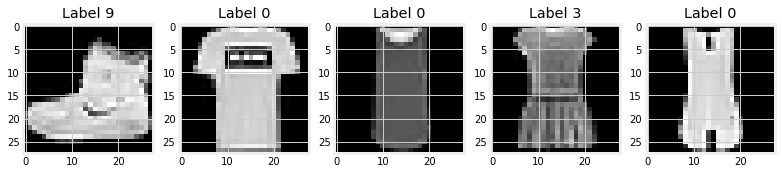

In [4]:
fig, ax = plt.subplots(1, 5, figsize=(12, 4))

for i in range(5):
    show_img = train_dataset[i][0].numpy().reshape(28, 28)
    label = train_dataset[i][1]
    ax[i].imshow(show_img, cmap='gray');
    ax[i].set_title(f"Label {label}")

### Maximum/minimum pixel values

In [6]:
min_pixel_value = train_dataset[0][0].min()
max_pixel_value = train_dataset[0][0].max()

print(f'Minimum pixel value: {min_pixel_value}')
print(f'Maximum pixel value: {max_pixel_value}')

Minimum pixel value: 0.0
Maximum pixel value: 1.0


### Create Model Class

In [8]:
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        # Encoder: affine function
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Decoder: affine function
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Encoder: affine function
        out = self.fc1(x)
        # Encoder: non-linear function
        out = F.leaky_relu(out)

        # Decoder: affine function
        out = self.fc2(out)
        # Decoder: non-linear function
        out = torch.sigmoid(out)

        return out

### Dimensions for overcomplete (larger latent representation)

In [9]:
input_dim = 28*28
hidden_dim = int(input_dim * 1.5)
output_dim = input_dim

model = FullyConnectedAutoencoder(input_dim, hidden_dim, output_dim)

### 손실함수 
- We want to minimize the per pixel reconstruction loss
-  So we've to use the mean squared error (MSE) loss
- This is similar to our regression tasks' loss

In [10]:
criterion = nn.MSELoss()

In [11]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [12]:
print(model)
# Parameter inspection
num_params_group = len(list(model.parameters()))
for group_idx in range(num_params_group):
    print(list(model.parameters())[group_idx].size())

FullyConnectedAutoencoder(
  (fc1): Linear(in_features=784, out_features=1176, bias=True)
  (fc2): Linear(in_features=1176, out_features=784, bias=True)
)
torch.Size([1176, 784])
torch.Size([1176])
torch.Size([784, 1176])
torch.Size([784])


In [13]:
idx = 0

# Dropout for creating noisy images
# by dropping out pixel with a 50% probability
dropout = nn.Dropout(0.5)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 28*28).requires_grad_()

        # Noisy images
        noisy_images = dropout(torch.ones(images.shape)) * images

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output
        outputs = model(noisy_images)

        # Calculate Loss: MSE Loss based on pixel-to-pixel comparison
        loss = criterion(outputs, images)

        # Getting gradients w.r.t. parameters via backpropagation
        loss.backward()

        # Updating parameters via gradient descent
        optimizer.step()

        idx += 1

        if idx % 500 == 0:
            # Calculate MSE Test Loss
            total_test_loss = 0
            total_samples = 0

            # Iterate through test dataset
            for images, labels in test_loader:
                # Noisy images
                noisy_images = dropout(torch.ones(images.shape)) * images

                # Forward pass only to get logits/output
                outputs = model(noisy_images.view(-1, 28*28))

                # Test loss
                test_loss = criterion(outputs, images.view(-1, 28*28))

                # Total number of labels
                total_samples += labels.size(0)

                # Total test loss
                total_test_loss += test_loss

            mean_test_loss = total_test_loss / total_samples

            # Print Loss
            print(f'Iteration: {idx}. Average Test Loss: {mean_test_loss.item()}.')

Iteration: 500. Average Test Loss: 0.0001622051786398515.
Iteration: 1000. Average Test Loss: 0.0001405961811542511.
Iteration: 1500. Average Test Loss: 0.00013072193542029709.
Iteration: 2000. Average Test Loss: 0.00012626373791135848.
Iteration: 2500. Average Test Loss: 0.00012122601037845016.
Iteration: 3000. Average Test Loss: 0.00011898799857590348.
Iteration: 3500. Average Test Loss: 0.0001159895327873528.
Iteration: 4000. Average Test Loss: 0.00011512373748701066.
Iteration: 4500. Average Test Loss: 0.00011273667769273743.


Label 4


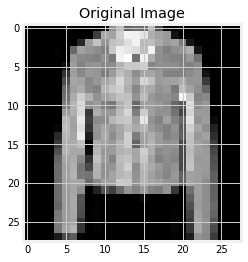

In [26]:
# Test sample: Raw
sample_num = 10
raw_img = test_dataset[sample_num][0]
show_img = raw_img.numpy().reshape(28, 28)
label = test_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');
plt.title('Original Image')
plt.show()

Label 4


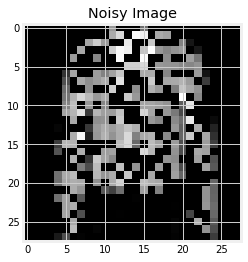

In [27]:
# Test sample: Noisy
sample_num = 10
raw_img = test_dataset[sample_num][0]
noisy_image = dropout(torch.ones(raw_img.shape)) * raw_img
show_img = noisy_image.numpy().reshape(28, 28)
label = test_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');
plt.title('Noisy Image')
plt.show()

Label 4


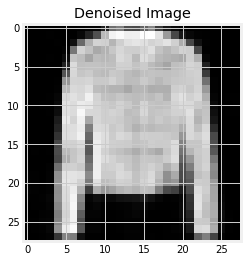

In [29]:
pred_image = model(noisy_image.reshape(1, 28 * 28))
show_img = pred_image.detach().numpy().reshape(28, 28)
label = test_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');
plt.title('Denoised Image')
plt.show()